# Covid-19 Analysis

This Notebook shows an analysis of the progression of the COVID-19 pandemic over time. The following analyses are provided:
* comparison of confirmed cases among different countries
* comparison of deaths among countries
* comparison of recovered cases among countries

For one selected country the logistic function (population function) is calculated and the model used to predict the future number of infected (confirmed) cases, as well as how long, in days, to reach 95% of total infected cases. These are plotted in the end of the Notebook.

The Logistic function (Population function):

$P(t)=\frac{K}{1+(\frac{K-P_{0}}{P_{0}})e^{-rt}}$

is the solution of the Verhulst differential equation:

$\frac{dP(t)}{dt}=rP(t).(1-\frac{P(t)}{K})$

where  P0  is the initial population, the constant  r  defines the growth rate and  K  is the carrying capacity.

the Notebook optimize.curve_fit function from scipy package to perform curve fitting.

Thanks to Devakumar kp <a>https://www.kaggle.com/imdevskp for providing the dataset:
    
<a>https://www.kaggle.com/imdevskp/corona-virus-report

The prediction model was inspired by the work of Hideto Manjo <a>https://www.kaggle.com/hotstaff
    
    published here: <a>https://www.kaggle.com/hotstaff/fitting-to-logistic-function-and-graph-drawing


In [61]:
#Setup and read dataset file. Souce in Kaggle, "imdevskp/corona-virus-report"
#Plotly is required. You'll need a username and corresponding api_key to connect to it and generate the plots online.
import chart_studio, zipfile, math
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import pylab as pl
from scipy.optimize import curve_fit
import datetime

In [62]:
initable = pd.read_table('covid-19.ini', delimiter=',', dtype={'Key':str, 'Value':str})
chart_studio.tools.set_credentials_file(username=initable.iloc[0,1], api_key=initable.iloc[1,1])
z = zipfile.ZipFile(initable.iloc[2,1])
dataset = pd.read_csv(z.open(initable.iloc[3,1]))
# drop non-interesting categories
del dataset["Lat"]
del dataset["Long"]
dataset.rename({"Province/State": "Province"}, axis=1, inplace=True)
dataset.rename({"Country/Region": "Country"}, axis=1, inplace=True)
series = []

In [63]:
interestingCountries=["France","Brazil", "US", "Italy", "Spain", "Germany", "New Zealand", "China", "Canada"]
highlightedCountries=['Brazil','Canada', 'New Zealand', 'Spain', 'China', "US"]
model_country = 'Brazil'
country_to_predict = 'Brazil'

In [64]:
# drop non-interesting Countries
dataset=dataset[dataset.Country.isin(interestingCountries)]
dataset

,Province,Country,Date,Confirmed,Deaths,Recovered
28,NaN,Brazil,1/22/20,0,0.0,0
35,Alberta,Canada,1/22/20,0,0.0,0
36,British Columbia,Canada,1/22/20,0,0.0,0
37,Grand Princess,Canada,1/22/20,0,0.0,0
38,Manitoba,Canada,1/22/20,0,0.0,0
...,...,...,...,...,...,...
20583,NaN,US,4/9/20,461437,16478.0,25410
20589,Diamond Princess,Canada,4/9/20,0,1.0,0
20602,Northwest Territories,Canada,4/9/20,5,0.0,0
20603,Yukon,Canada,4/9/20,7,0.0,0


<h5>Find 'Confirmed' cases

In [65]:
confirmedresultset=dataset.groupby(['Country','Date']).agg({'Confirmed': sum})
confirmedresultset.reset_index(level=['Date'], inplace=True) #put Date back to column
confirmedresultset['Date']=pd.to_datetime(confirmedresultset['Date'], format='%m/%d/%y') #convert column to type Date
confirmedresultset=confirmedresultset.sort_values(['Country','Date'], ascending=True) #sort by Country then Date
confirmedresultset['DailyChange']=confirmedresultset['Confirmed'].diff()
confirmedresultset['Days']=0
confirmedresultset.loc[confirmedresultset['DailyChange']<0,"DailyChange"]=np.nan
for country in interestingCountries:
    length=len(confirmedresultset.loc[country,'Days'])
    dayOne=next((i for i, x in enumerate(confirmedresultset[confirmedresultset.index == country].Confirmed) if x), length)
    confirmedresultset.loc[country,"Days"][dayOne:length]=range(1,length-dayOne+1) # 1st day with a Confirmed case
confirmedresultset


c:\users\lozas\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\series.py:1042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\lozas\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Confirmed,DailyChange,Days
Country,,,,
Brazil,2020-01-22,0,NaN,0
Brazil,2020-01-23,0,0.0,0
Brazil,2020-01-24,0,0.0,0
Brazil,2020-01-25,0,0.0,0
Brazil,2020-01-26,0,0.0,0
...,...,...,...,...
US,2020-04-05,337072,28219.0,75
US,2020-04-06,366667,29595.0,76
US,2020-04-07,396223,29556.0,77


<h5>Find 'Deaths' cases

In [66]:
deathsresultset=dataset.groupby(['Country','Date']).agg({'Deaths': sum})
deathsresultset.reset_index(level=['Date'], inplace=True) #put Date back to column
deathsresultset['Date']=pd.to_datetime(deathsresultset['Date'], format='%m/%d/%y') #convert column to type Date
deathsresultset=deathsresultset.sort_values(['Country','Date'], ascending=True) #sort by Country then Date
deathsresultset['DailyChange']=deathsresultset['Deaths'].diff()
deathsresultset['Days']=0
deathsresultset.loc[deathsresultset['DailyChange']<0,"DailyChange"]=np.nan
for country in interestingCountries:
    length=len(deathsresultset.loc[country,'Days'])
    dayOne=next((i for i, x in enumerate(deathsresultset[deathsresultset.index == country].Deaths) if x), length)
    deathsresultset.loc[country,"Days"][dayOne:length]=range(1,length-dayOne+1) # 1st day with a Death case
deathsresultset

c:\users\lozas\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\series.py:1042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\lozas\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Deaths,DailyChange,Days
Country,,,,
Brazil,2020-01-22,0.0,NaN,0
Brazil,2020-01-23,0.0,0.0,0
Brazil,2020-01-24,0.0,0.0,0
Brazil,2020-01-25,0.0,0.0,0
Brazil,2020-01-26,0.0,0.0,0
...,...,...,...,...
US,2020-04-05,9619.0,1212.0,37
US,2020-04-06,10783.0,1164.0,38
US,2020-04-07,12722.0,1939.0,39


<h5>Find 'Recovered' cases

In [67]:
recoveredresultset=dataset.groupby(['Country','Date']).agg({'Recovered': sum})
recoveredresultset.reset_index(level=['Date'], inplace=True) #put Date back to column
recoveredresultset['Date']=pd.to_datetime(recoveredresultset['Date'], format='%m/%d/%y') #convert column to type Date
recoveredresultset=recoveredresultset.sort_values(['Country','Date'], ascending=True) #sort by Country then Date
recoveredresultset['DailyChange']=recoveredresultset['Recovered'].diff()
recoveredresultset['Days']=0
recoveredresultset.loc[recoveredresultset['DailyChange']<0,"DailyChange"]=np.nan
for country in interestingCountries:
    length=len(recoveredresultset.loc[country,'Days'])
    dayOne=next((i for i, x in enumerate(recoveredresultset[recoveredresultset.index == country].Recovered) if x), length)
    recoveredresultset.loc[country,'Days'][dayOne:length]=range(1,length-dayOne+1) # 1st day with a recovered case
recoveredresultset

c:\users\lozas\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\series.py:1042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\lozas\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Recovered,DailyChange,Days
Country,,,,
Brazil,2020-01-22,0,NaN,0
Brazil,2020-01-23,0,0.0,0
Brazil,2020-01-24,0,0.0,0
Brazil,2020-01-25,0,0.0,0
Brazil,2020-01-26,0,0.0,0
...,...,...,...,...
US,2020-04-05,17448,2796.0,57
US,2020-04-06,19581,2133.0,58
US,2020-04-07,21763,2182.0,59


<h4>Confirmed cases graphic

In [68]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=confirmedresultset[confirmedresultset.index == country].Date, 
            y=confirmedresultset[confirmedresultset.index == country].Confirmed, 
            name=country+" Confirmed", 
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            )
        )

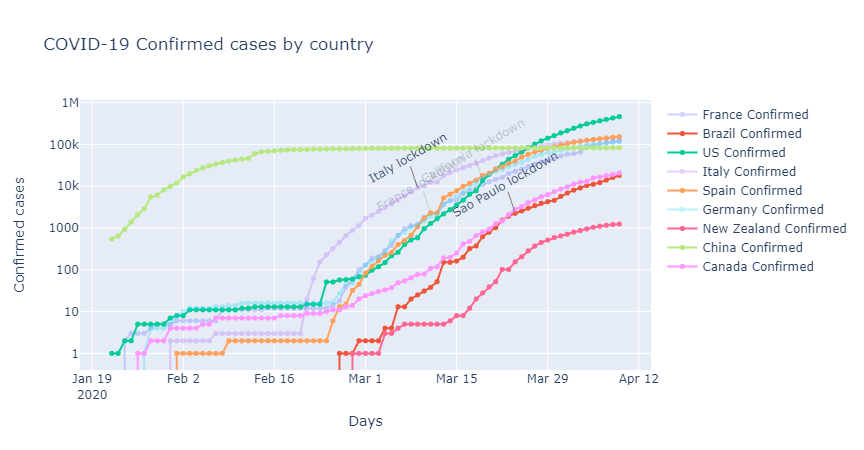

In [69]:
figcc = go.Figure(series)
figcc.update_layout(title_text='COVID-19 Confirmed cases by country')
figcc.update_xaxes(title_text='Days')
figcc.update_yaxes(title_text='Confirmed cases', type='log')
figcc.add_annotation(
        x='2020-03-24',
        y=math.log(2247,10), xref="x", yref="y",
        text="Sao Paulo lockdown", textangle = 330, showarrow=True, arrowcolor='grey')
figcc.add_annotation(
        x='2020-03-09',
        y=math.log(9172,10), xref="x", yref="y",
        text="Italy lockdown", textangle = 330, showarrow=True, arrowcolor='grey')
figcc.add_annotation(
        x='2020-03-11',
        y=math.log(2293,10), xref="x", yref="y",
        text="France lockdown", textangle = 330, showarrow=True, arrowcolor='grey', opacity=0.3)
figcc.add_annotation(
        x='2020-03-19',
        y=math.log(13677,10), xref="x", yref="y",
        text="California lockdown", textangle = 330, showarrow=True, arrowcolor='grey', opacity=0.3)
#py.iplot(figcc, file='covid-19.html', auto_open=False)
figcc.show()

<h4>Confirmed cases evolution

In [70]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=confirmedresultset[confirmedresultset.index == country].Days, 
            y=confirmedresultset[confirmedresultset.index == country].Confirmed, 
            name=country+" Confirmed", 
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            )
        )

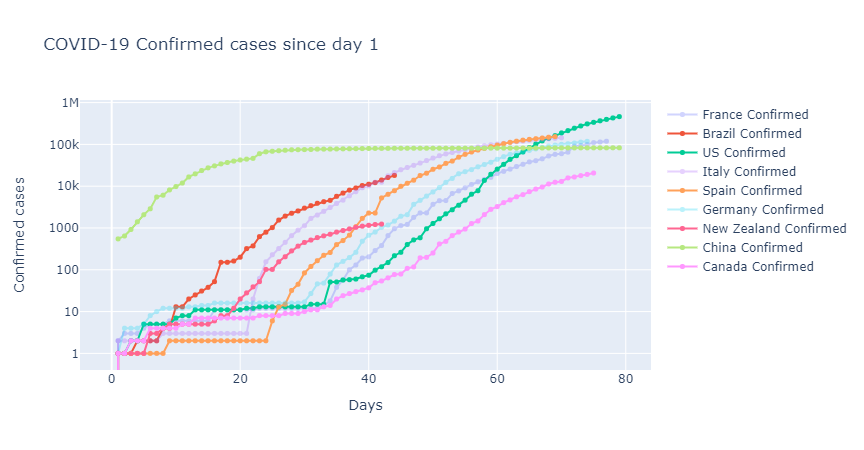

In [71]:
figcc = go.Figure(series)
figcc.update_layout(title_text='COVID-19 Confirmed cases since day 1')
figcc.update_xaxes(title_text='Days')
figcc.update_yaxes(title_text='Confirmed cases', type='log')
figcc.show()

<h4>New Confirmed cases

In [72]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=confirmedresultset[confirmedresultset.index == country].Date, 
            y=confirmedresultset[confirmedresultset.index == country].DailyChange, 
            name=country+" new confirmed", 
            mode="markers", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            )
        )

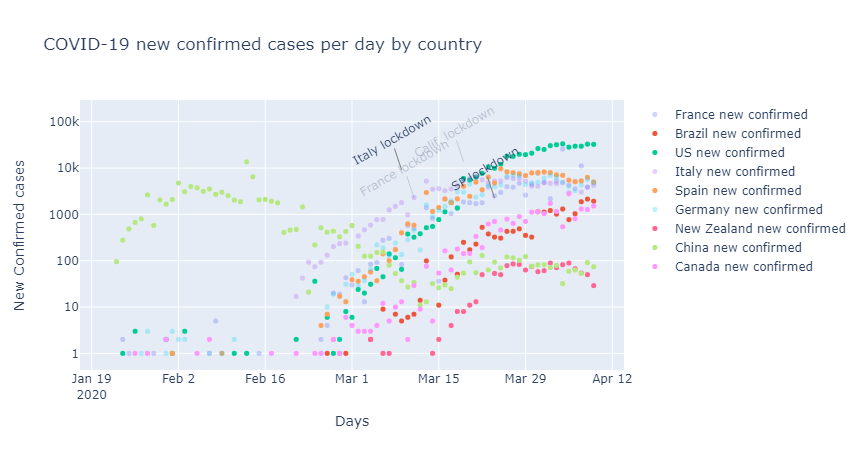

In [73]:
fignc = go.Figure(series)
fignc.update_layout(title_text='COVID-19 new confirmed cases per day by country')
fignc.update_xaxes(title_text='Days')
fignc.update_yaxes(title_text='New Confirmed cases', type='log')
fignc.add_annotation(
        x='2020-03-24',
        y=math.log(2247,10), xref="x", yref="y",
        text="SP lockdown", textangle = 330, showarrow=True, arrowcolor='grey')
fignc.add_annotation(
        x='2020-03-09',
        y=math.log(9172,10), xref="x", yref="y",
        text="Italy lockdown", textangle = 330, showarrow=True, arrowcolor='grey')
fignc.add_annotation(
        x='2020-03-11',
        y=math.log(2293,10), xref="x", yref="y",
        text="France lockdown", textangle = 330, showarrow=True, arrowcolor='grey', opacity=0.3)
fignc.add_annotation(
        x='2020-03-19',
        y=math.log(13677,10), xref="x", yref="y",
        text="Calif. lockdown", textangle = 330, showarrow=True, arrowcolor='grey', opacity=0.3)
#py.iplot(fignc, file='covid-19.html', auto_open=False)
fignc.show()

<h4>New Confirmed cases per day

In [74]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=confirmedresultset[confirmedresultset.index == country].Days, 
            y=confirmedresultset[confirmedresultset.index == country].DailyChange, 
            name=country+" new confirmed", 
            mode="markers", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            )
        )

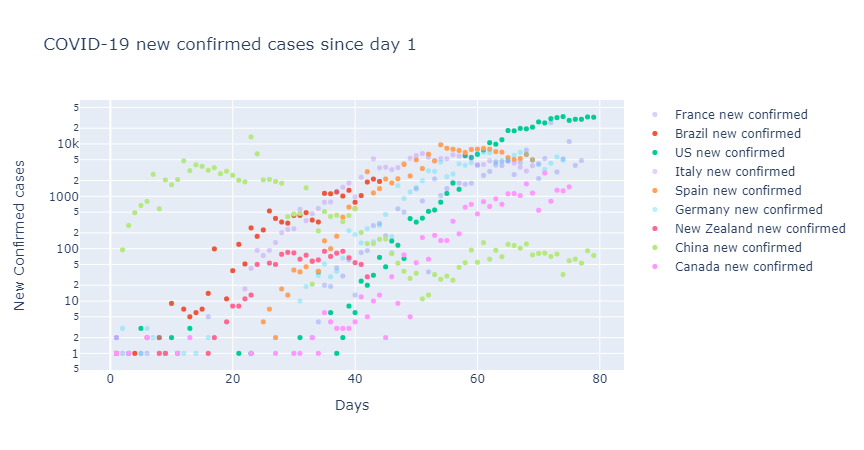

In [75]:
fignc = go.Figure(series)
fignc.update_layout(title_text='COVID-19 new confirmed cases since day 1')
fignc.update_xaxes(title_text='Days')
fignc.update_yaxes(title_text='New Confirmed cases', type='log')
fignc.show()

In [76]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=deathsresultset[deathsresultset.index == country].Date, 
            y=deathsresultset[deathsresultset.index == country].Deaths, 
            name=country+" Deaths",
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
        )
    )

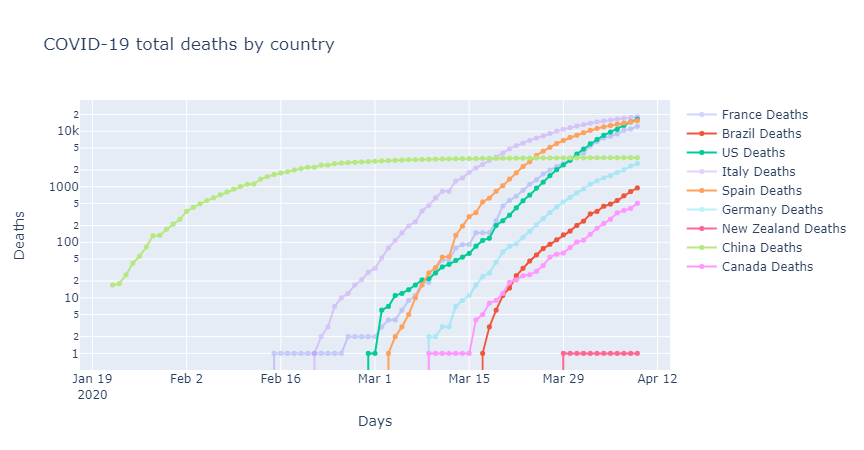

In [77]:
figdc = go.Figure(series)
figdc.update_layout(title_text='COVID-19 total deaths by country')
figdc.update_xaxes(title_text='Days')
figdc.update_yaxes(title_text='Deaths', type='log')
#py.iplot(figdc, file='covid-19.html', auto_open=False)
figdc.show()

<h5> New Deaths per day

In [78]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=deathsresultset[deathsresultset.index == country].Date, 
            y=deathsresultset[deathsresultset.index == country].DailyChange, 
            name=country+" new deaths", 
            mode="markers", opacity=focus,
            marker={"symbol":"circle", "size": 5}, 
            )
        )

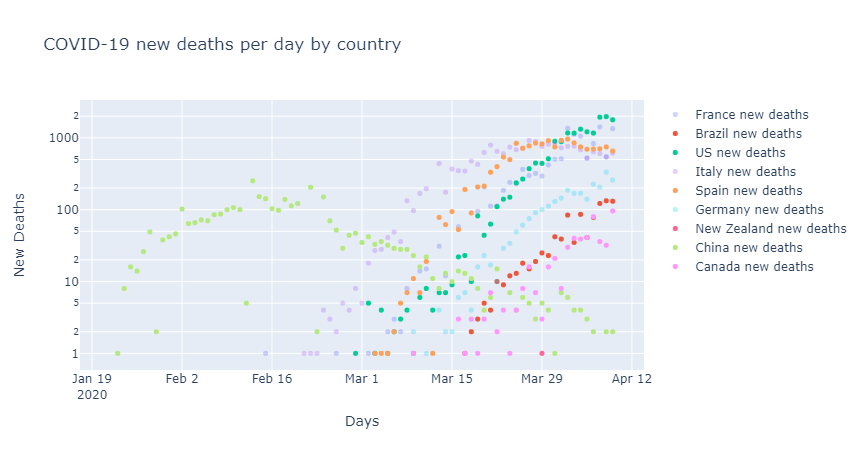

In [79]:
fignd = go.Figure(series)
fignd.update_layout(title_text='COVID-19 new deaths per day by country')
fignd.update_xaxes(title_text='Days')
fignd.update_yaxes(title_text='New Deaths', type='log')
#py.iplot(fignd, file='covid-19.html', auto_open=False)
fignd.show()

<h4>Recovered cases

In [80]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=recoveredresultset[recoveredresultset.index == country].Date, 
            y=recoveredresultset[recoveredresultset.index == country].Recovered, 
            name=country+" Recovered",
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
        )
    )

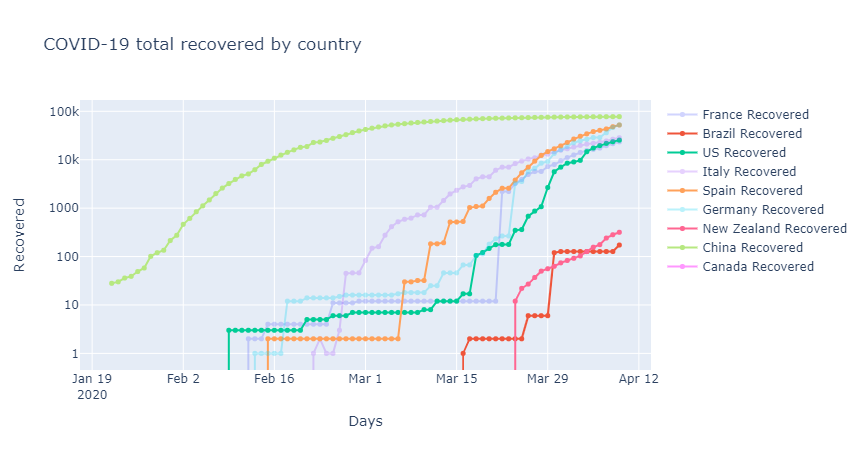

In [81]:
fig = go.Figure(series)
fig.update_layout(title_text='COVID-19 total recovered by country')
fig.update_xaxes(title_text='Days')
fig.update_yaxes(title_text='Recovered', type='log')
#py.iplot(fig, file='covid-19.html', auto_open=False)
fig.show()

<h5>New Recovered cases per day

In [82]:
series = []
for country in interestingCountries: 
    if country in highlightedCountries:
        focus = 1
    else:
        focus = 0.3
    series.append(
        go.Scatter(
            x=recoveredresultset[recoveredresultset.index == country].Date, 
            y=recoveredresultset[recoveredresultset.index == country].DailyChange, 
            name=country+" new recovered", 
            mode="markers", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            )
        )

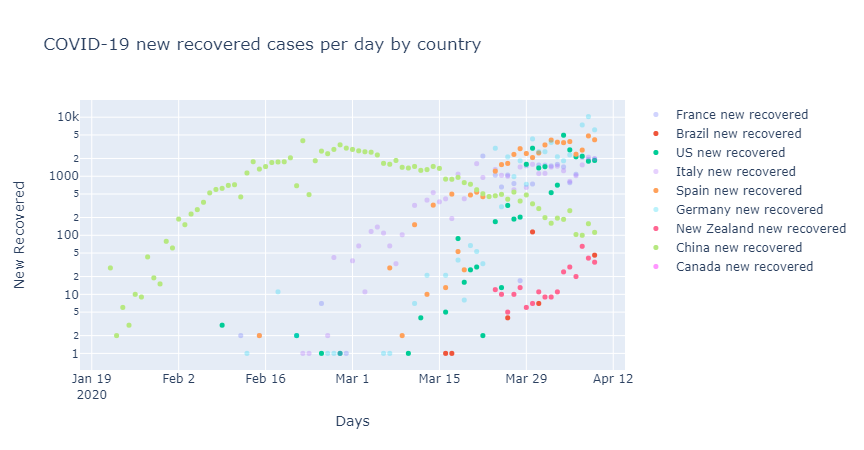

In [83]:
fig = go.Figure(series)
fig.update_layout(title_text='COVID-19 new recovered cases per day by country')
fig.update_xaxes(title_text='Days')
fig.update_yaxes(title_text='New Recovered', type='log')
#py.iplot(fig, file='covid-19.html', auto_open=False)
fig.show()

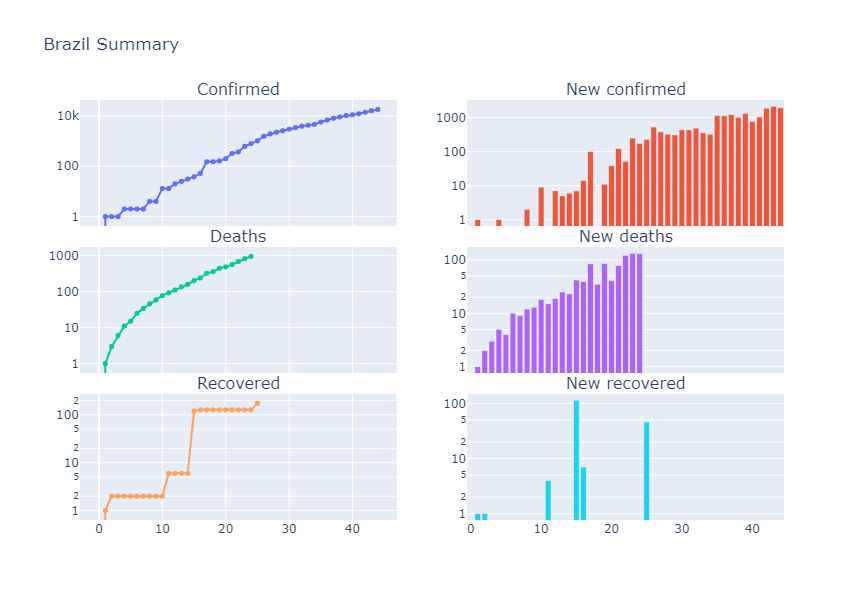

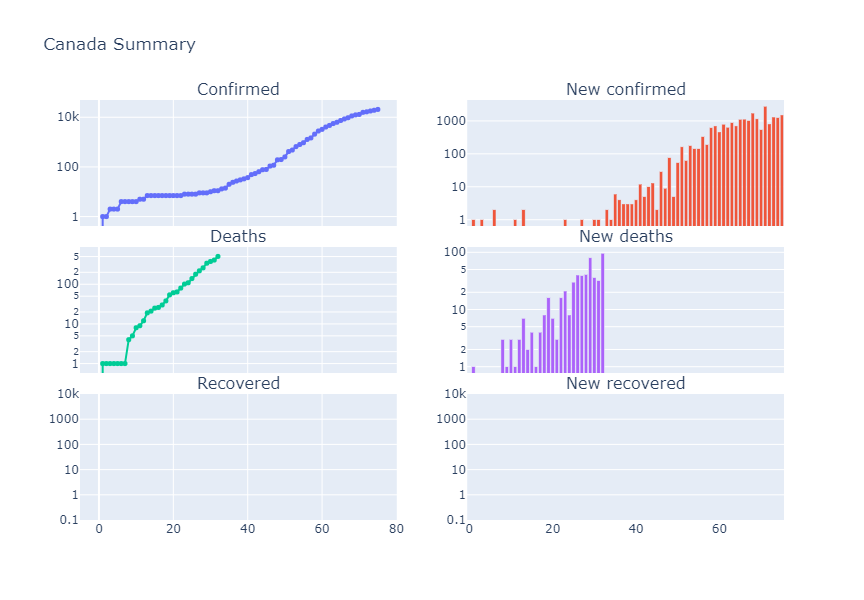

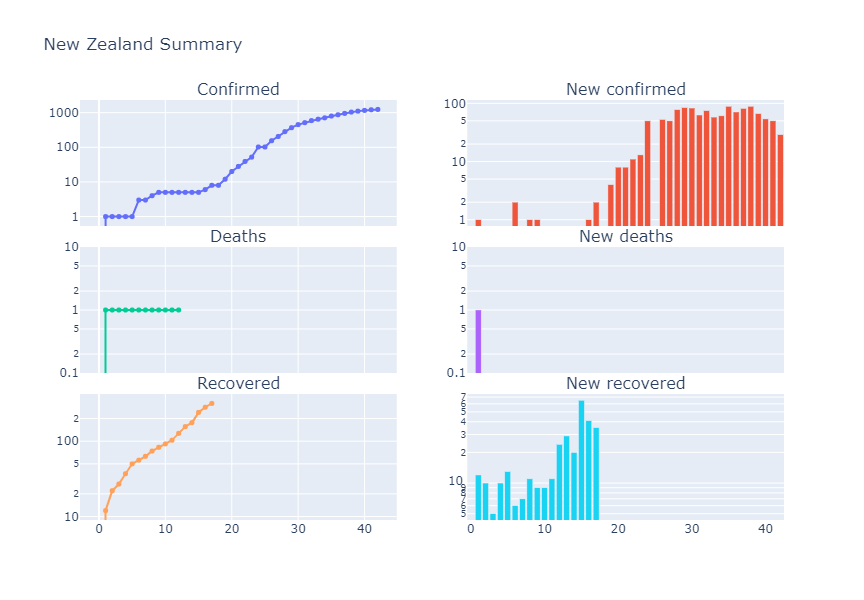

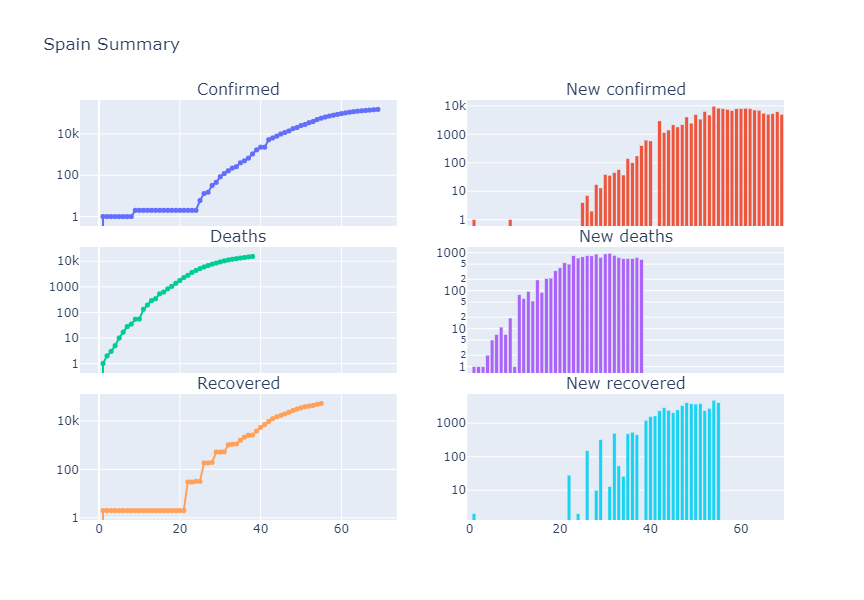

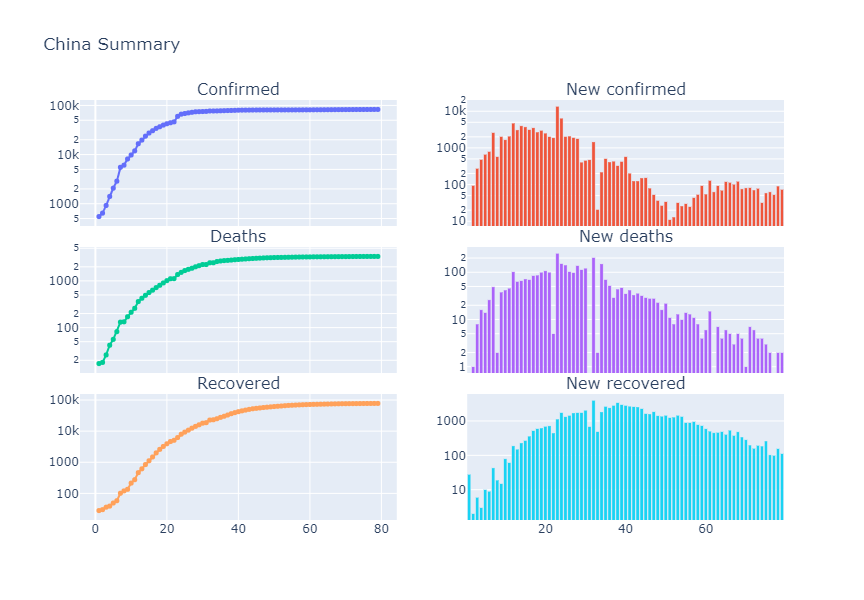

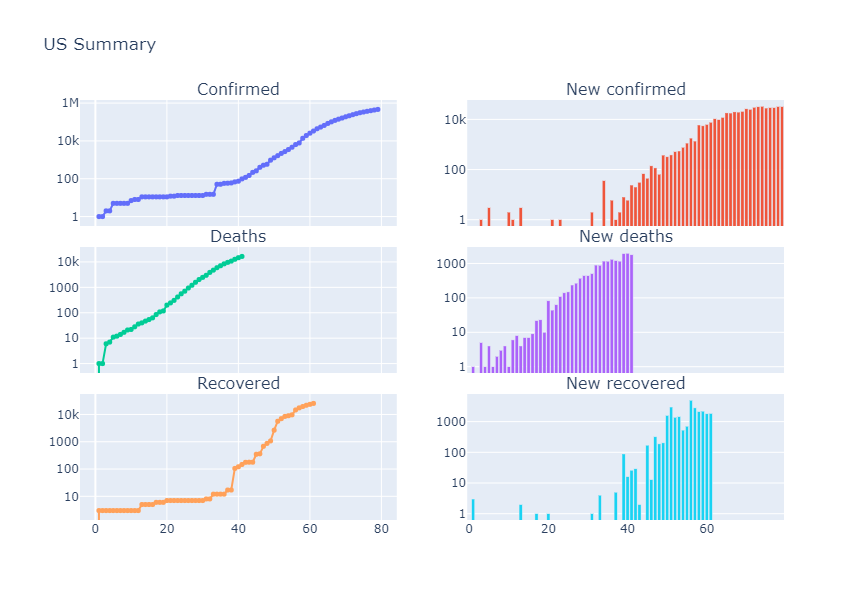

In [84]:
for country in highlightedCountries:
    focus=1
    figbr = make_subplots(
        rows=3, cols=2,
        shared_xaxes=True,
        vertical_spacing=0.05,
        specs=[[{"type": "scatter"},
               {"type": "scatter"}],
               [{"type": "scatter"},
               {"type": "scatter"}],
               [{"type": "scatter"},
               {"type": "scatter"}]],
        subplot_titles=("Confirmed", "New confirmed", 
                        "Deaths", "New deaths", 
                        "Recovered", "New recovered")
    )
    figbr.add_trace(
        go.Scatter(
            x=confirmedresultset[confirmedresultset.index == country].Days, 
            y=confirmedresultset[confirmedresultset.index == country].Confirmed, 
            name="Confirmed", 
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            ),
        row=1, col=1
    )
    figbr.add_trace(
        go.Bar(
            x=confirmedresultset[confirmedresultset.index==country].Days, 
            y=confirmedresultset[confirmedresultset.index==country].DailyChange, 
            name=" New confirmed",   
        ),
        row=1, col=2    
    )    
    figbr.add_trace(
        go.Scatter(
            x=deathsresultset[deathsresultset.index == country].Days, 
            y=deathsresultset[deathsresultset.index == country].Deaths, 
            name="Total deaths",
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
        ),
        row=2, col=1   

    )    
    figbr.add_trace(
        go.Bar(
            x=deathsresultset[deathsresultset.index == country].Days, 
            y=deathsresultset[deathsresultset.index == country].DailyChange, 
            name="New deaths", 
            ),
        row=2, col=2  
    )
    figbr.add_trace(
    go.Scatter(
            x=recoveredresultset[recoveredresultset.index == country].Days, 
            y=recoveredresultset[recoveredresultset.index == country].Recovered, 
            name="Total Recovered",
            mode="markers+lines", opacity=focus,
            marker={"symbol":"circle", "size": 5},
            ), 
        row=3,col=1
    )
    figbr.add_trace(
        go.Bar(
            x=recoveredresultset[recoveredresultset.index == country].Days, 
            y=recoveredresultset[recoveredresultset.index == country].DailyChange, 
            name="New recovered", 
            ), 
        row=3,col=2
    )
    figbr.update_layout(
        height=600,
        showlegend=False,
        title_text=country+ " Summary",
    )
    figbr.update_yaxes(type='log')
    figbr.show()

In [85]:
# fit logistic function to country 

x_values = confirmedresultset[confirmedresultset.index ==model_country]['Days'].values.tolist() 
y_values = confirmedresultset[confirmedresultset.index ==model_country]['Confirmed'].values.tolist()

for c, value in enumerate(confirmedresultset[confirmedresultset.index ==model_country]['Date']):
    if value == datetime.datetime.strptime("2020-03-24", '%Y-%m-%d').date():
        lockdownday=confirmedresultset[confirmedresultset.index ==model_country].Days[c]

# fitting functions
def f(t, K, P0, r):
    return  (K / (1 + ((K-P0)/P0)*np.exp(-r*t)))

# fitting
popt, pcov = curve_fit(f, x_values, y_values, p0=[1, 1, 0.5], maxfev=300000)
print(f"Fitting parameters")
print(f"K: {popt[0]}, P0: {popt[1]}, r: {popt[2]}")

Fitting parameters
K: 41927.062738015935, P0: 18.2723206071528, r: 0.16879708473099825


In [86]:
# prediction country
x_values = confirmedresultset[confirmedresultset.index ==country_to_predict]['Days'].values.tolist() 
y_values = confirmedresultset[confirmedresultset.index ==country_to_predict]['Confirmed'].values.tolist()

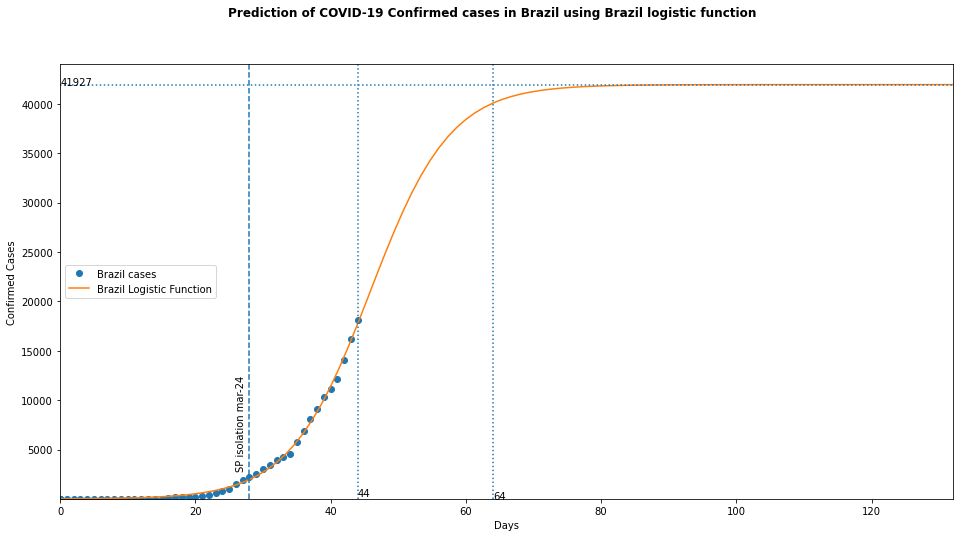

In [106]:
##### init main graph
fig = pl.figure(figsize=(16, 8))
ax = pl.axes()

# main graph captions
pl.suptitle("Prediction of COVID-19 Confirmed cases in "+country_to_predict+ " using "+ model_country + " logistic function", fontweight="bold")
pl.ylabel('Confirmed Cases')
pl.xlabel('Days')

# main fitting plot
xx = np.linspace(0, x_values[-1]*3, 100, endpoint=True)
yy = f(xx, popt[0], popt[1], popt[2])
pl.xlim(xx[0], xx[-1])
pl.ylim(yy[0], yy[-1]*1.05)

# find day when reaching 95% of deaths
day95pc =0
for c, value in enumerate(yy):
    if value > yy[-1]*.95:
        day95pc = c
        break   
lastdatapointday = confirmedresultset[confirmedresultset.index ==country_to_predict]['Days'][-1]        

pl.plot(x_values, y_values,'o', label=country_to_predict+' cases')
pl.plot(xx, yy, label=model_country+" Logistic Function")
pl.legend(loc='center left')
pl.axhline(y=yy[-1], ls=':',)
pl.axvline(x=xx[day95pc], ls=':')
ax.annotate(str("%.0f" % round(yy[-1], 0)),xy=(0, yy[-1]))
pl.axvline(x=lastdatapointday, ls=':')
ax.annotate(str("%.0f" % lastdatapointday), xy=(lastdatapointday,250))
ax.annotate(str("%.0f" % xx[day95pc]), xy=(xx[day95pc],25))
ax.annotate("SP isolation mar-24", xy=(lockdownday-2,3000), rotation=90)
pl.axvline(x=lockdownday, ls='--')

# Any results you write to the current directory are saved as output.
pl.savefig("graph.png")

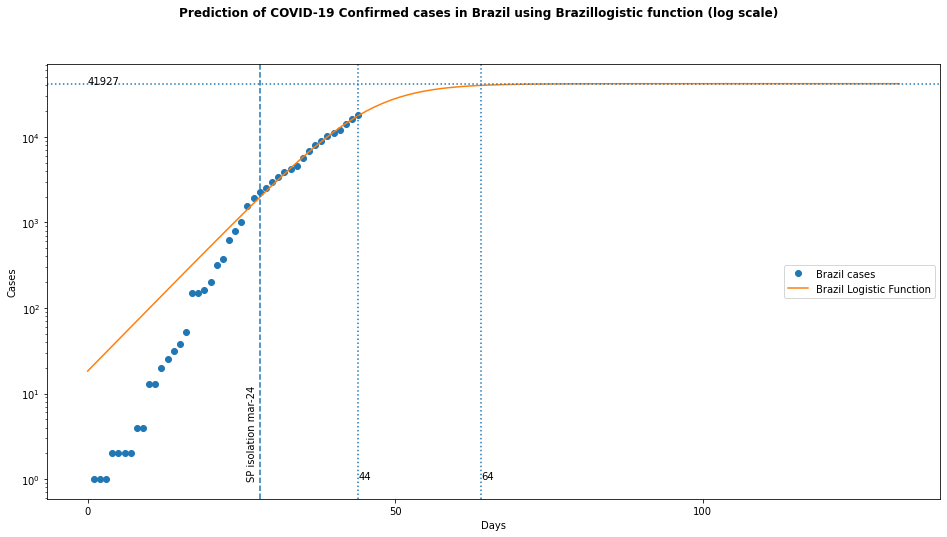

In [107]:
# init main graph
fig = pl.figure(figsize=(16, 8))
ax = pl.axes()

# main graph captions
pl.suptitle("Prediction of COVID-19 Confirmed cases in "+country_to_predict+" using "+model_country+"logistic function (log scale)", fontweight="bold")
pl.ylabel('Cases')
pl.xlabel('Days')

pl.yscale('Log')
pl.locator_params(axis='x',tight=True, nbins=5)
pl.plot(x_values, y_values,'o', label=country_to_predict+' cases')
pl.plot(xx, yy, label=model_country+" Logistic Function")
pl.legend(loc='center right')
pl.axhline(y=yy[-1], ls=':',)
pl.axvline(x=xx[day95pc], ls=':')
ax.annotate(str("%.0f" % round(yy[-1], 0)),xy=(0, yy[-1]))
pl.axvline(x=lastdatapointday, ls=':')
ax.annotate(str("%.0f" % lastdatapointday), xy=(lastdatapointday,1))
ax.annotate(str("%.0f" % xx[day95pc]), xy=(xx[day95pc],1))
ax.annotate("SP isolation mar-24", xy=(lockdownday-2,1), rotation=90)
pl.axvline(x=lockdownday, ls='--')
# Any results you write to the current directory are saved as output.
pl.savefig("graph_log.png")

The prediction curves shown as *Brazil Logistic Function* above, seem to indicate that Brazil will reach 95% of the total of cases by day 64 of the pandemic. This date is 18 April 29th. The model predicts 41927 confirmed cases in Brazil.

The log chart suggests that after the isolation measure taken in SP (Sao Paulo), the curve appears to have reduced the slope, which seems to confirm that the isolation measures are reducing the contagion. 